# Learning word embeddings - CBOW

The aim of this experiment is to learn word embeddings from text usig the Continuous Bag of Words (CBOW) model architecture described by [*Tomas Mikolov et al.*](https://arxiv.org/pdf/1301.3781v3.pdf)

## The Continuous Bag of Words model

The CBOW model attempts to predict a word given its context.

$$ p (w_o | w_i) = \frac{ exp(v'^{T} _{w_o} \cdot v_{w_i})  }{ \sum^{W}_{w=1}  exp(v'^{T} _{w} \cdot v_{w_i} ) } $$

$$ E = -log\ p(w_o\ |\ w_{i1},\ w_{i2},\ \dots,\ w_{ic}) $$

where $vi$ and $vo$ are input and output word vectors.

Input = sum of context vectors

Output = Word vector

In [1]:
import tensorflow as tf

For the data, I'm using the [text8 dataset](http://mattmahoney.net/dc/textdata) which is a 100MB sample of cleaned English Wikipedia dump on Mar. 3, 2006

In [2]:
import os, urllib

    
def fetch_data(url):
    
    filename = url.split("/")[-1]
    datadir = os.path.join(os.getcwd(), "data")
    filepath = os.path.join(datadir, filename)
    
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    if not os.path.exists(filepath):
        urllib.urlretrieve(url, filepath)
    
    return filepath

url = "http://mattmahoney.net/dc/text8.zip"
filepath = fetch_data(url)
print ("Data at {0}.".format(filepath))

Data at /home/saurabhmathur96/notebook/data/text8.zip.


In [3]:
import os, zipfile

def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


words = read_data(filepath)
print ("data_size = {0}".format(len(words)))

data_size = 17005207


Take only the top $c$ words, mark rest as UNK (unknown).

In [4]:
import collections

def build_dataset(words, vocabulary_size):
    count = [[ "UNK", -1 ]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    word_to_index = { word: i for i, (word, _) in enumerate(count) }
    data = [word_to_index.get(word, 0) for word in words] # map unknown words to 0
    unk_count = data.count(0) # Number of unknown words
    count[0][1] = unk_count
    index_to_word= dict(zip(word_to_index.values(), word_to_index.keys()))
    
    return data, count, word_to_index, index_to_word

vocabulary_size = 50000
data, count, word_to_index, index_to_word = build_dataset(words, vocabulary_size)
print ("data: {0}".format(data[:5]))
print ("count: {0}".format(count[:5]))
print ("word_to_index: {0}".format(word_to_index.items()[:5]))
print ("index_to_word: {0}".format(index_to_word.items()[:5]))

data: [5239, 3084, 12, 6, 195]
count: [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
word_to_index: [('fawn', 45848), ('homomorphism', 9648), ('nordisk', 39343), ('nunnery', 36075), ('chthonic', 33554)]
index_to_word: [(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one')]


In [11]:
import numpy as np
import collections

def generate_batch(data_index, data_size, batch_size, bag_window):
    span = 2 * bag_window + 1 # [ bag_window target bag_window ]
    batch = np.ndarray(shape = (batch_size, span - 1), dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    
    data_buffer = collections.deque(maxlen = span)
    
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
        
    for i in range(batch_size):
        data_list = list(data_buffer)
        labels[i, 0] = data_list.pop(bag_window)
        batch[i] = data_list
        
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print ("data = {0}".format([index_to_word[each] for each in data[:16]]))
data_index, data_size, batch_size = 0, len(data), 4
for bag_window in [1, 2]:
    _, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
    print ("bag_window = {0}".format(bag_window))
    print ("batch = {0}".format([[index_to_word[index] for index in each] for each in batch]))
    print ("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(4)]))
    

data = ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']
bag_window = 1
batch = [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
labels = ['originated', 'as', 'a', 'term']

bag_window = 2
batch = [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
labels = ['as', 'a', 'term', 'of']



In [18]:
import math

batch_size = 128
embedding_size = 128
bag_window = 2
num_sampled = 64

graph = tf.Graph()
with graph.as_default():
    #
    # Input data
    train_data = tf.placeholder(tf.int32, [batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, [batch_size, 1])
    
    #
    # Variables
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev = 1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    #
    # Model
    embed = tf.nn.embedding_lookup(embeddings, train_data)
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, tf.reduce_sum(embed, 1),
                              train_labels, num_sampled, vocabulary_size))
    
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
    normalized_embeddings = embeddings / norm

In [28]:
num_steps = 50001

with tf.Session(graph=graph) as sess:
    tf.initialize_all_variables().run()
    average_loss = 0
    
    for step in range(num_steps):
        _, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
        feed_dict = { train_data: batch, train_labels: labels }
        _, current_loss = sess.run([optimizer, loss], feed_dict = feed_dict)
        average_loss += current_loss
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                print ("step = {0}, average_loss = {1}".format(step, average_loss))
                average_loss = 0
    
    final_embeddings = normalized_embeddings.eval()

step = 2000, average_loss = 0.173457223163
step = 4000, average_loss = 0.000380429101264
step = 6000, average_loss = 0.000103445848203
step = 8000, average_loss = 3.96371572879e-05
step = 10000, average_loss = 1.2845975046e-05
step = 12000, average_loss = 4.43783402136e-06
step = 14000, average_loss = 1.76276631368e-06
step = 16000, average_loss = 6.09936405684e-07
step = 18000, average_loss = 2.30055124471e-07
step = 20000, average_loss = 1.07183750432e-07
step = 22000, average_loss = 2.51288953007e-08
step = 24000, average_loss = 6.25217517255e-08
step = 26000, average_loss = 7.15346512883e-09
step = 28000, average_loss = 4.28128531421e-09
step = 30000, average_loss = 2.91084767964e-09
step = 32000, average_loss = 2.33529055887e-09
step = 34000, average_loss = 1.84541500786e-09
step = 36000, average_loss = 1.70711392944e-09
step = 38000, average_loss = 1.93342237639e-09
step = 40000, average_loss = 3.78017311717e-09
step = 42000, average_loss = 1.384869624e-09
step = 44000, average_l

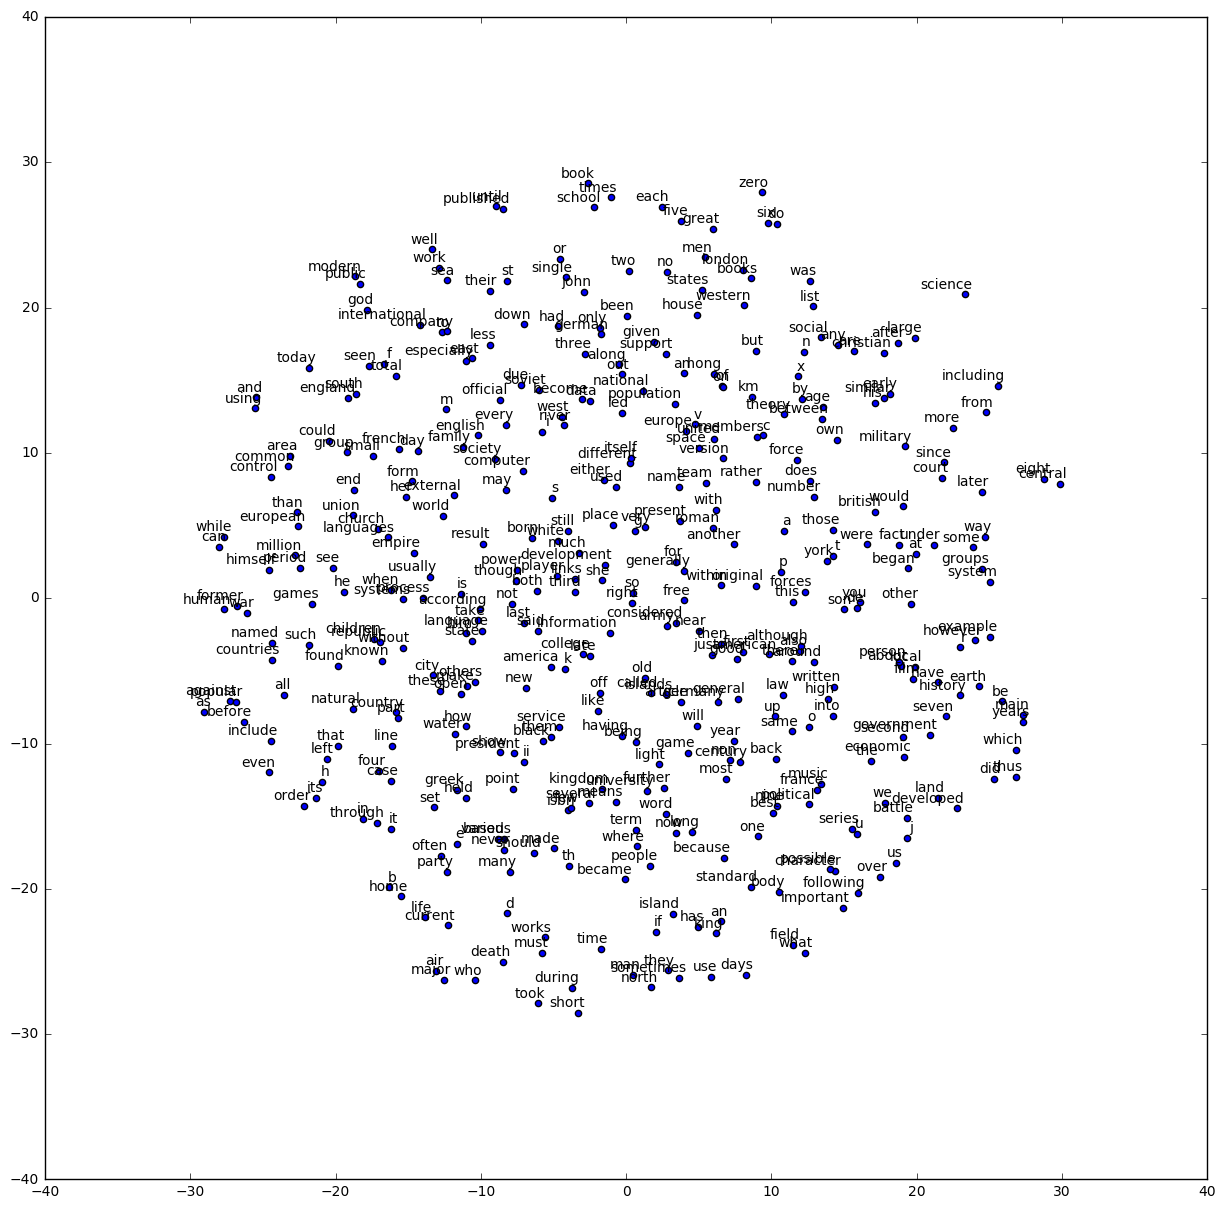

In [30]:
from matplotlib import pylab
from sklearn.manifold import TSNE

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

pylab.figure(figsize=(15,15))
words = [index_to_word[i] for i in range(1, num_points+1)]
for i, label in enumerate(words):
    x, y = two_d_embeddings[i, :]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
pylab.show()